In [1]:
# load packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import sklearn

%matplotlib inline

import pandas
import pickle
import pydot

Using TensorFlow backend.
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framewo

In [4]:
# import the data, Butte
dataButte = np.load('Butte/data_nadj4_stdTrue.npy')
dataLabelsButte = np.load('Butte/labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabelsButte),1))
temp[:,0] = dataLabelsButte
dataLabelsButte = temp

# Kaweah
dataKaweah = np.load('Kaweah/data_nadj4_stdTrue.npy')
dataLabelsKaweah = np.load('Kaweah/labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabelsKaweah),1))
temp[:,0] = dataLabelsKaweah
dataLabelsKaweah = temp

#data.closest_pos.hist()

In [5]:
print(np.shape(dataKaweah),np.shape(dataButte))

(24523, 4, 9, 37) (23411, 4, 9, 37)


In [6]:
# do the do for Butte
# reshuffle the vectors
data_preped=np.transpose(dataButte, (0, 2, 3, 1))

# set large values to mean of that dimension
for k in range(0,37):
    for m in range(0,4):
        
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData
        
# look at the data
#plt.hist(data_preped[:,4,28,1])

# set nans to 0 (there shouldnt be any but who knows)
X_Butte=np.nan_to_num(data_preped)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X_Butte)[-1]):
    for j in range(np.shape(X_Butte)[1]):
        
        # do it for all examples, for this moment
        X_Butte[:,j,:,i] = min_max_scaler.fit_transform(X_Butte[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X_Butte)[2]):
            if i==1 or i==3:
                if k>=28:
                    X_Butte[:,j,k,i]=X_Butte[:,j,k,i]-X_Butte[:,j,k,i]

# reshuffle the vectors for Kaweah
data_preped=np.transpose(dataKaweah, (0, 2, 3, 1))

# set large values to mean of that dimension
for k in range(0,37):
    for m in range(0,4):
        
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData
        
# look at the data
#plt.hist(data_preped[:,4,28,1])

# set nans to 0 (there shouldnt be any but who knows)
X_Kaweah=np.nan_to_num(data_preped)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X_Kaweah)[-1]):
    for j in range(np.shape(X_Kaweah)[1]):
        
        # do it for all examples, for this moment
        X_Kaweah[:,j,:,i] = min_max_scaler.fit_transform(X_Kaweah[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X_Kaweah)[2]):
            if i==1 or i==3:
                if k>=28:
                    X_Kaweah[:,j,k,i]=X_Kaweah[:,j,k,i]-X_Kaweah[:,j,k,i]

                    
# combine them
X_both=np.concatenate((X_Butte,X_Kaweah),axis=0)
dataLabelsBoth=np.concatenate((dataLabelsButte,dataLabelsKaweah),axis=0)


D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


In [7]:
print(np.shape(X_Butte),np.shape(X_Kaweah),np.shape(X_both))

(23411, 9, 37, 4) (24523, 9, 37, 4) (47934, 9, 37, 4)


In [25]:
# make some random indices, then take 20000 examples for training and the rest for test, results in about 85/15 split
# first is butte on butte
indices=np.random.permutation(X_Butte.shape[0])
X_train1=X_Butte[indices[:20000],:,:,:]
X_test1=X_Butte[indices[20000:],:,:,:]
Y_train1=dataLabelsButte[indices[:20000],:]
Y_test1=dataLabelsButte[indices[20000:],:]

# 2nd is Kaweah on Kaweah
indices=np.random.permutation(X_Kaweah.shape[0])
X_train2=X_Kaweah[indices[:20000],:,:,:]
X_test2=X_Kaweah[indices[20000:],:,:,:]
Y_train2=dataLabelsKaweah[indices[:20000],:]
Y_test2=dataLabelsKaweah[indices[20000:],:]

# 3rd is both on both
indices=np.random.permutation(X_both.shape[0])
X_train3=X_both[indices[:41000],:,:,:]
X_test3=X_both[indices[41000:],:,:,:]
Y_train3=dataLabelsBoth[indices[:41000],:]
Y_test3=dataLabelsBoth[indices[41000:],:]

# 4th is butte on Kaweah
X_train4=X_Butte
X_test4=X_Kaweah
Y_train4=dataLabelsButte
Y_test4=dataLabelsKaweah

# 5th is Kaweah on Butte
X_train5=X_Kaweah
X_test5=X_Butte
Y_train5=dataLabelsKaweah
Y_test5=dataLabelsButte

# 6th is butte with 0.5% of Kaweah
percentToUse=0.5
indices=np.random.permutation(X_Kaweah.shape[0])
X_train6=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test6=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train6=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test6=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]

# 7th is butte with 1% of Kaweah
percentToUse=1
indices=np.random.permutation(X_Kaweah.shape[0])
X_train7=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test7=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train7=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test7=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]

# 8th is butte with 0.1% of Kaweah
percentToUse=0.1
indices=np.random.permutation(X_Kaweah.shape[0])
X_train8=np.concatenate((X_Butte,X_Kaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:,:,:]),axis=0)
X_test8=X_Kaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:,:,:]
Y_train8=np.concatenate((dataLabelsButte,dataLabelsKaweah[indices[:np.int(np.round(485000*(percentToUse/100)))],:]),axis=0)
Y_test8=dataLabelsKaweah[indices[np.int(np.round(485000*(percentToUse/100))):],:]


# print out some shit
print ("number of training examples = " + str(X_train1.shape[0]))
print ("number of test examples = " + str(X_test1.shape[0]))
print ("X_train1 shape: " + str(X_train1.shape))
print ("Y_train1 shape: " + str(Y_train1.shape))
print ("X_test1 shape: " + str(X_test1.shape))
print ("Y_test1 shape: " + str(Y_test1.shape))

print ("number of training examples = " + str(X_train2.shape[0]))
print ("number of test examples = " + str(X_test2.shape[0]))
print ("X_train2 shape: " + str(X_train2.shape))
print ("Y_train2 shape: " + str(Y_train2.shape))
print ("X_test2 shape: " + str(X_test2.shape))
print ("Y_test2 shape: " + str(Y_test2.shape))

print ("number of training examples = " + str(X_train3.shape[0]))
print ("number of test examples = " + str(X_test3.shape[0]))
print ("X_train3 shape: " + str(X_train3.shape))
print ("Y_train3 shape: " + str(Y_train3.shape))
print ("X_test3 shape: " + str(X_test3.shape))
print ("Y_test3 shape: " + str(Y_test3.shape))

print ("number of training examples = " + str(X_train4.shape[0]))
print ("number of test examples = " + str(X_test4.shape[0]))
print ("X_train4 shape: " + str(X_train4.shape))
print ("Y_train4 shape: " + str(Y_train4.shape))
print ("X_test4 shape: " + str(X_test4.shape))
print ("Y_test4 shape: " + str(Y_test4.shape))

print ("number of training examples = " + str(X_train6.shape[0]))
print ("number of test examples = " + str(X_test6.shape[0]))
print ("X_train6 shape: " + str(X_train6.shape))
print ("Y_train6 shape: " + str(Y_train6.shape))
print ("X_test6 shape: " + str(X_test6.shape))
print ("Y_test6 shape: " + str(Y_test6.shape))

# look at a timegate to check the scaling
#plt.hist(X[:,1,3,0].flatten())

number of training examples = 20000
number of test examples = 3411
X_train1 shape: (20000, 9, 37, 4)
Y_train1 shape: (20000, 1)
X_test1 shape: (3411, 9, 37, 4)
Y_test1 shape: (3411, 1)
number of training examples = 20000
number of test examples = 4523
X_train2 shape: (20000, 9, 37, 4)
Y_train2 shape: (20000, 1)
X_test2 shape: (4523, 9, 37, 4)
Y_test2 shape: (4523, 1)
number of training examples = 41000
number of test examples = 6934
X_train3 shape: (41000, 9, 37, 4)
Y_train3 shape: (41000, 1)
X_test3 shape: (6934, 9, 37, 4)
Y_test3 shape: (6934, 1)
number of training examples = 23411
number of test examples = 24523
X_train4 shape: (23411, 9, 37, 4)
Y_train4 shape: (23411, 1)
X_test4 shape: (24523, 9, 37, 4)
Y_test4 shape: (24523, 1)
number of training examples = 25836
number of test examples = 22098
X_train6 shape: (25836, 9, 37, 4)
Y_train6 shape: (25836, 1)
X_test6 shape: (22098, 9, 37, 4)
Y_test6 shape: (22098, 1)


In [26]:
def model(input_shape):

    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((3, 3))(X_input)
    
    # initializer to use
    initToUse=keras.initializers.glorot_normal(seed=0)
    #initToUse=keras.initializers.he_normal(seed=0)
    
    # for the leakly relu
    alphaParam=0.3

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (2, 3), strides = (1, 1), kernel_initializer=initToUse, name = 'conv0', padding='same')(X_input)
    X = MaxPooling2D((1, 2), name='max_pool0')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(32, (2, 5), strides = (1, 1), kernel_initializer=initToUse, name = 'conv1', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool1')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(64, (2, 7), strides = (1, 1), kernel_initializer=initToUse, name = 'conv2', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool2')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 9), strides = (1, 1), kernel_initializer=initToUse, name = 'conv3', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 11), strides = (1, 1), kernel_initializer=initToUse, name = 'conv4', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_final')(X)
    
    # make another initializer
    initToUse2=keras.initializers.he_normal(seed=0)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(200, activation='relu', kernel_initializer=initToUse2,name='fc0')(X)
    X = Dense(100, activation='relu', kernel_initializer=initToUse2,name='fc1')(X)
    X = Dense(50, activation='relu', kernel_initializer=initToUse2,name='fc2')(X)
    X = Dense(1, activation='sigmoid', kernel_initializer=initToUse,name='fc3')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    ### END CODE HERE ###
    
    return model


def modelv2(inputShape,L2param,alpha):

    model = keras.models.Sequential()
    
    # make the initializer
    initToUse=keras.initializers.glorot_normal(seed=1)
    initToUse2=keras.initializers.he_normal(seed=1)

    # for the leakly relu
    alphaParam=alpha
    
    # short dim
    shortDim=3
    
    # add some regularization to the dense layers
    denseReg=keras.regularizers.l2(L2param)
    
    # add some conv layers
    model.add(Conv2D(16, (shortDim, 3), input_shape=inputShape, kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(32, (shortDim, 5), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(64, (shortDim, 7), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (shortDim, 9), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    # flatten and do some dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(160, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(96, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(32, activation='relu', kernel_regularizer=denseReg))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

def modelv3(inputShape,L2,alpha):

    model = keras.models.Sequential()
    
    # make the initializer
    initToUse=keras.initializers.glorot_normal(seed=1)
    initToUse2=keras.initializers.he_normal(seed=1)
    
    # short dim
    shortDim=3
    
    # add some regularization to the dense layers
    denseReg=keras.regularizers.l2(L2)
    
    # add some conv layers
    model.add(Conv2D(16, (shortDim, 3), input_shape=inputShape, kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, (shortDim, 5), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(64, (shortDim, 7), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (shortDim, 9), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    #model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alpha))
    
    # flatten and do some dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(256, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(160, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(96, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(32, activation='relu', kernel_regularizer=denseReg))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

def trainEnsemble(modelType,ensembleSize,currTrainX,currTrainY,currTestX,currTestY,currLearingRate,currEpochNum,currL2param,currBatchSize,trialEpochNum,currAlphaParam,verbFlag):
    
    # make a list of models and other lists and arrays we need
    test_acc=np.zeros((ensembleSize,1))
    Models=[]
    adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=currLearingRate)
    
    # train the ensemble of models
    for i in range(ensembleSize):
        
        # make the flag for checking if the training got stuck
        whileFlag=1
        while whileFlag==1:

            # make the model based on the model type
            if modelType==1:
                tempModel = modelv2(currTrainX.shape[1:],currL2param,currAlphaParam)
            elif modelType==2:
                tempModel = modelv3(currTrainX.shape[1:],currL2param,currAlphaParam)
                

            # compile the model
            tempModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

            # fit the model
            tempModel.fit(x = currTrainX, y = currTrainY, epochs = trialEpochNum, batch_size = currBatchSize,  verbose=verbFlag)

            # test to see if it was stuck
            temp=tempModel.evaluate(x = currTrainX, y = currTrainY)

            if (temp[1]*100)>73:

                # train for all the epochs
                tempModel.fit(x = currTrainX, y = currTrainY, epochs = currEpochNum, batch_size = currBatchSize,  verbose=verbFlag)

                # predict and store the results
                temp=tempModel.evaluate(x = currTestX, y = currTestY)
                test_acc[i]=temp[1]

                # append the model and end the while loop
                Models.append(tempModel)
                whileFlag=0

    test_acc_var=np.var(100*test_acc)

    # get the mean label, round it and find the emsemble test acc
    meanLabels=(Models[0].predict(currTestX)+Models[1].predict(currTestX)+Models[2].predict(currTestX)+Models[3].predict(currTestX)+Models[4].predict(currTestX))/5
    meanLabels=np.round(meanLabels)
    wrongLabels=currTestY-meanLabels
    test_acc_mean=1-np.sum(np.abs(wrongLabels))/len(currTestY)

    print("\n Final ensemble test accuracy of: ",str(np.round(test_acc_mean*100,2)),", mean test accuracy of:",np.str(np.round(np.mean(test_acc)*100,2)),"with a std of: ",str(np.round(test_acc_var,2)))

    return Models, test_acc_mean, test_acc_var, test_acc, meanLabels

def reset_keras():
    
    # if the stuff below doesnt work do this
    K.clear_session()
    
    sess = K.get_session()
    K.clear_session()
    sess.close()
    sess = K.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    #print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = K.tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    K.set_session(K.tf.Session(config=config))

In [27]:
# set the random seed
np.random.seed(2)

# Butte on butte, 99%
#result1 = trainEnsemble(1,5,X_train1,Y_train1,X_test1,Y_test1,0.0008,20,0.001,480,20,0.2,0)

# Kaweah on Kaweah, 99%
#result2 = trainEnsemble(1,5,X_train2,Y_train2,X_test2,Y_test2,0.0008,20,0.001,480,20,0.2,0)

# both on both, 99%
#result3 = trainEnsemble(1,5,X_train3,Y_train3,X_test3,Y_test3,0.0008,20,0.001,480,20,0.2,0)

# butte on Kaweah, 59%
#result4 = trainEnsemble(1,5,X_train4,Y_train4,X_test4,Y_test4,0.0008,20,0.001,480,20,0.2,0)

# Butte on Kaweah with 0.1% of Kaweah (last run got 90%)
result8 = trainEnsemble(1,5,X_train8,Y_train8,X_test8,Y_test8,0.0008,50,0.001,480,20,0.2,0)

# Butte on Kaweah with 0.5% of Kaweah
result6 = trainEnsemble(1,5,X_train6,Y_train6,X_test6,Y_test6,0.0008,50,0.001,480,20,0.2,0)

# Butte on Kaweah with 1% of Kaweah (last run for 99%)
result7 = trainEnsemble(1,5,X_train7,Y_train7,X_test7,Y_test7,0.0008,50,0.001,480,20,0.2,0)


23808/24038 [============================>.] - ETA: 0s
 Final ensemble test accuracy of:  92.4 , mean test accuracy of: 87.15 with a std of:  14.83
21600/22098 [============================>.] - ETA: 0s
 Final ensemble test accuracy of:  98.53 , mean test accuracy of: 96.17 with a std of:  6.66
19424/19673 [============================>.] - ETA: 0s
 Final ensemble test accuracy of:  99.34 , mean test accuracy of: 98.81 with a std of:  0.13


In [42]:
# DOING THIS IN THE .PY SCRIPT NOT HERE DUE TO GPU MEMORY OVERFLOW

# stochastic hyper parameter optimization

# set the random seed
#np.random.seed(2)

# set the number of stoachastic samples
#examplesToRun=100

# set epochs
#trialEpochNum=20
#epochNumArray=np.random.randint(200, 401, size=(examplesToRun,))

# set the learning rate, l2 param and batch size
#learningRateArray=np.power(np.random.randint(1, 10, size=(examplesToRun,)).astype('float64'),-1*np.random.randint(4, 6, size=(examplesToRun,)))
#l2paramArray=np.power(np.random.randint(1, 10, size=(examplesToRun,)).astype('float64'),-1*np.random.randint(2, 4, size=(examplesToRun,)))
#batchSizeArray=np.random.randint(200, 601, size=(examplesToRun,))  # best was 475 but 480 is a multiple of 32, fits in memory better?

# set the alpha for the leakly relu
#alphaParamArray=np.power(np.random.randint(1, 10, size=(examplesToRun,)).astype('float64'),-1*np.random.randint(1, 3, size=(examplesToRun,)))

# make empty arrays
#results=[]
#test_acc_array=[]
#test_acc_mat=[]
#for i in range(examplesToRun):
    
    # run an ensemble for three different epoch numbers
    #temp = trainEnsemble(1,5,X_train,learningRateArray[i],epochNumArray[i],l2paramArray[i],batchSizeArray[i],trialEpochNum,alphaParamArray[i],1)
    #temp = trainEnsemble(1,5,X_train,0.0008,epochNumArray[i],l2paramArray[i],batchSizeArray[i],trialEpochNum,alphaParamArray[i],1)
    #temp = trainEnsemble(2,5,X_train,0.0008,200,0.1,512,trialEpochNum,0.3,1)
    #reset_keras()
    #results.append(temp)
    #test_acc_array.append(temp[1])
    #test_acc_mat.append(temp[3])
    
    
#np.savetxt('test_acc_array.txt', test_acc_array, delimiter=',')
#np.savetxt('test_acc_mat.txt', test_acc_mat, delimiter=',')
#np.savetxt('input_params.txt', (epochNumArray,l2paramArray,batchSizeArray,alphaParamArray), delimiter=',')


In [47]:
# previous results

# with l2 reg of 0.01 got:
# Final ensemble test accuracy of:  94.53 , mean test accuracy of: 92.86 with a std of:  0.28

# with l2 reg of 0.001 got:
# Final ensemble test accuracy of:  95.23 , mean test accuracy of: 92.68 with a std of:  2.86

# with l2 reg of 0.001 and 350 instead of 250 epochs (like the above runs) got:
# Final ensemble test accuracy of:  94.88 , mean test accuracy of: 93.49 with a std of:  0.16, runtime 1hr 6min 10s

# with l2 reg of 0.0001 and 250 epochs again got:
# Final ensemble test accuracy of:  94.46 , mean test accuracy of: 92.25 with a std of:  0.11, runtime 51min 48s

# with l2 reg of 0.001 and epochNum=[160, 170, 180, 190, 200, 210, 220, 230, 240, 250] above 170
# all but one were 94% or higher, 6 and a half hours to run this

# with l2 reg of 0.001 and epochNum=[150, 200, 250] and model type 2, all above were model type 1
# got 91.45, 93.68, 94.13
result7[0][0]

In [49]:
def show_confusion_matrix(C,class_labels=['0','1'],innerTextFS=12):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=18)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''], fontsize=14)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=18, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90, fontsize=14)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.04,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),fontsize=innerTextFS)


    plt.tight_layout()
    #plt.show()

In [50]:
currResult=result6
currTest=X_test6
meanLabels=(currResult[0][0].predict(currTest)+currResult[0][1].predict(currTest)+currResult[0][2].predict(currTest)+currResult[0][3].predict(currTest)+currResult[0][4].predict(currTest))/5
meanLabels=np.round(meanLabels)


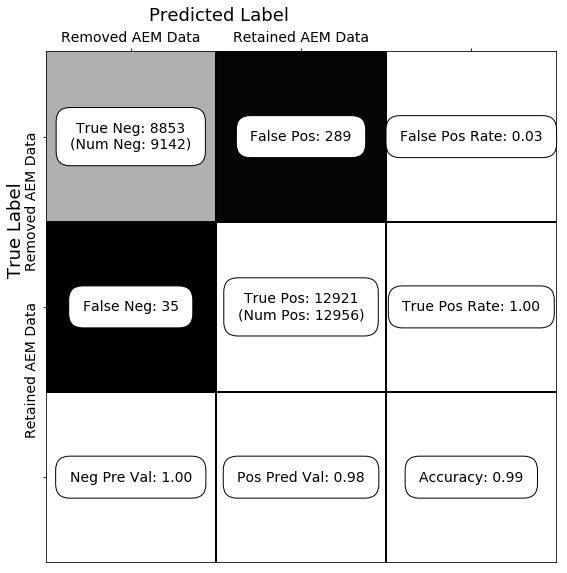

In [52]:
confusionMat = sklearn.metrics.confusion_matrix(Y_test6,meanLabels)

show_confusion_matrix(confusionMat, ['Removed AEM Data', 'Retained AEM Data'],14)
plt.savefig('confusionMat_Butte_on_K_w_05pct.png')

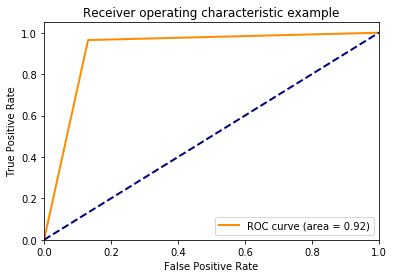

In [34]:
# didn't end up using this

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
y = label_binarize(Y_test6, classes=[0, 1])
y_meanlab = label_binarize(meanLabels, classes=[0, 1])
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_meanlab[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_meanlab.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [51]:
result7[0][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_231 (Conv2D)          (None, 9, 37, 16)         592       
_________________________________________________________________
max_pooling2d_231 (MaxPoolin (None, 9, 18, 16)         0         
_________________________________________________________________
leaky_re_lu_231 (LeakyReLU)  (None, 9, 18, 16)         0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 9, 18, 32)         7712      
_________________________________________________________________
max_pooling2d_232 (MaxPoolin (None, 9, 9, 32)          0         
_________________________________________________________________
leaky_re_lu_232 (LeakyReLU)  (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 9, 9, 64)          43072     
__________

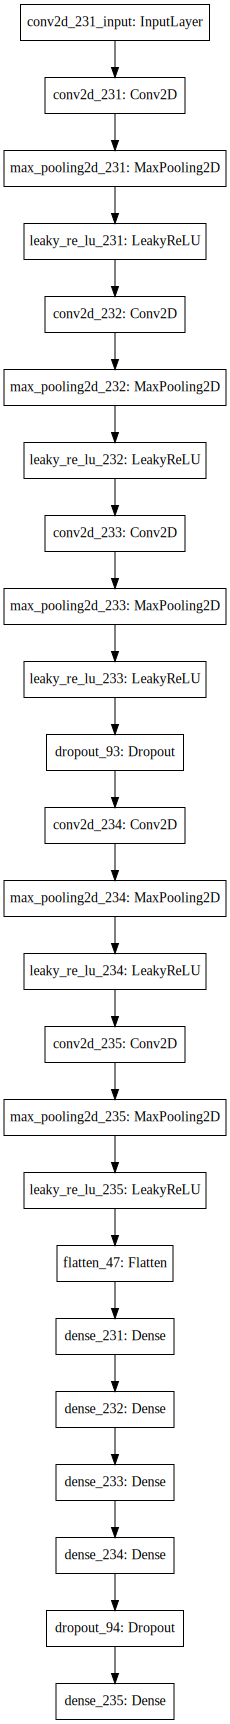

In [52]:
plot_model(result7[0][0], to_file='Model_graph.png')
SVG(model_to_dot(result7[0][0]).create(prog='dot', format='svg'))